In [2]:
# Importera bibliotek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
from datetime import datetime

In [3]:
# Läs in data från CSV-filer
movies = pd.read_csv('../backend/data/processed/filtered_movies.csv')
ratings = pd.read_csv('../backend/data/processed/filtered_ratings.csv')

# Skriv ut information om dataseten för att verifiera inläsningen
print(f"Movies shape: {movies.shape}")
print(f"Ratings shape: {ratings.shape}")

Movies shape: (9611, 5)
Ratings shape: (81116, 5)


In [4]:
# Visa detaljerad information om varje dataset
for df, name in zip([movies, ratings], ['Movies', 'Ratings']):
    print(f"\n{name} dataset info:")
    print(df.info())  # Visar datatyper och icke-null värden
    print("\nFirst few rows:")
    print(df.head())  # Visar de första raderna i datasetet
    print("\nMissing values:")
    print(df.isnull().sum())  # Kontrollerar om det finns några saknade värden


Movies dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9611 entries, 0 to 9610
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9611 non-null   int64  
 1   title        9611 non-null   object 
 2   genres       9611 non-null   object 
 3   year         9611 non-null   float64
 4   genre_count  9611 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 375.6+ KB
None

First few rows:
   movieId                               title   
0        1                    Toy Story (1995)  \
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres    year  genre_count  
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0            5  
1                   Adventure|Children|Fantasy  199

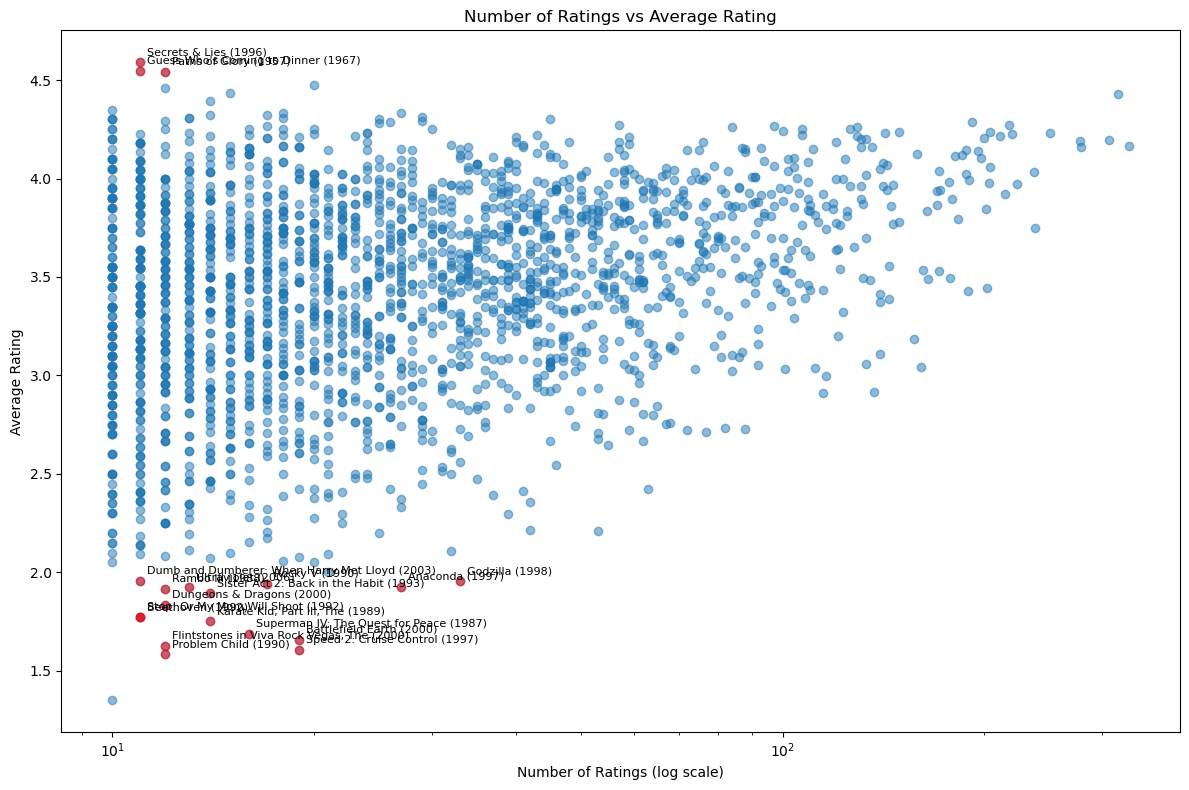

Potential outliers:
                                                  title  rating_count   
movieId                                                                 
1041                              Secrets & Lies (1996)            11  \
1178                              Paths of Glory (1957)            12   
1499                                    Anaconda (1997)            27   
1556                     Speed 2: Cruise Control (1997)            19   
1882                                    Godzilla (1998)            33   
2404                                   Rambo III (1988)            12   
2412                                     Rocky V (1990)            17   
2422                   Karate Kid, Part III, The (1989)            14   
2643            Superman IV: The Quest for Peace (1987)            16   
2798                               Problem Child (1990)            12   
3248             Sister Act 2: Back in the Habit (1993)            14   
3268                  Stop! Or 

In [5]:
# Analysera potentiella outliers i betygsdata

# Beräkna statistik för varje film
movie_stats = ratings.groupby('movieId').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['rating_count', 'rating_mean']

# Skapa en scatter plot för att visualisera relationen mellan antal betyg och genomsnittligt betyg
plt.figure(figsize=(12, 8))
plt.scatter(movie_stats['rating_count'], movie_stats['rating_mean'], alpha=0.5)
plt.xscale('log')
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Rating')
plt.title('Number of Ratings vs Average Rating')

# Identifiera och markera potentiella outliers
outliers = movie_stats[(movie_stats['rating_count'] > 10) & ((movie_stats['rating_mean'] < 2) | (movie_stats['rating_mean'] > 4.5))]
plt.scatter(outliers['rating_count'], outliers['rating_mean'], color='red', alpha=0.5)

# Lägg till etiketter för outliers
for idx, row in outliers.iterrows():
    plt.annotate(movies.loc[movies['movieId'] == idx, 'title'].values[0],
                 (row['rating_count'], row['rating_mean']),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Skriv ut information om potentiella outliers
print("Potential outliers:")
outlier_info = movies[movies['movieId'].isin(outliers.index)][['movieId', 'title']]
print(pd.concat([outlier_info.set_index('movieId'), outliers], axis=1))

# Denna analys hjälper oss att identifiera filmer med ovanligt höga eller låga betyg,
# vilket kan indikera mycket populära eller impopulära filmer, eller potentiella dataproblem

In [6]:
# Skapa features för filmerna
def create_features(movies, ratings):
    # Extrahera år från filmtitel
    movies['year'] = movies['title'].str.extract('(\d{4})').astype(float)
    
    # Beräkna genomsnittsbetyg och antal betyg för varje film
    movie_stats = ratings.groupby('movieId').agg({'rating': ['count', 'mean']})
    movie_stats.columns = ['rating_count', 'rating_mean']
    
    # Skapa dummy-variabler för genrer
    genre_dummies = movies['genres'].str.get_dummies(sep='|')
    
    # Kombinera alla features
    features = pd.concat([movies[['movieId', 'year']], movie_stats, genre_dummies], axis=1)
    
    # Lägg till en feature för filmens ålder
    current_year = datetime.now().year
    features['movie_age'] = current_year - features['year']
    
    # Lägg till en feature för filmens popularitet (antal betyg)
    features['popularity'] = features['rating_count']
    
    # Lägg till en feature för filmens "kvalitet" (genomsnittligt betyg)
    features['quality'] = features['rating_mean']
    
    # Skapa en feature för "trendighet" (nyare filmer med många betyg)
    features['trendiness'] = features['popularity'] * (1 / (features['movie_age'] + 1))
    
    return features

# Använd funktionen för att skapa features
movie_features = create_features(movies, ratings)
print(movie_features.head())
print("\nFeature columns:")
print(movie_features.columns)

# Denna funktion skapar en rad olika features som kan vara användbara för rekommendationssystemet,
# inklusive år, popularitet, kvalitet och trendighet

   movieId    year  rating_count  rating_mean  Action  Adventure  Animation   
0      1.0  1995.0           NaN          NaN     0.0        1.0        1.0  \
1      2.0  1995.0         215.0     3.920930     0.0        1.0        0.0   
2      3.0  1995.0         110.0     3.431818     0.0        0.0        0.0   
3      4.0  1995.0          52.0     3.259615     0.0        0.0        0.0   
4      5.0  1995.0           NaN          NaN     0.0        0.0        0.0   

   Children  Comedy  Crime  ...  Mystery  Romance  Sci-Fi  Thriller  War   
0       1.0     1.0    0.0  ...      0.0      0.0     0.0       0.0  0.0  \
1       1.0     0.0    0.0  ...      0.0      0.0     0.0       0.0  0.0   
2       0.0     1.0    0.0  ...      0.0      1.0     0.0       0.0  0.0   
3       0.0     1.0    0.0  ...      0.0      1.0     0.0       0.0  0.0   
4       0.0     1.0    0.0  ...      0.0      0.0     0.0       0.0  0.0   

   Western  movie_age  popularity   quality  trendiness  
0      0.0

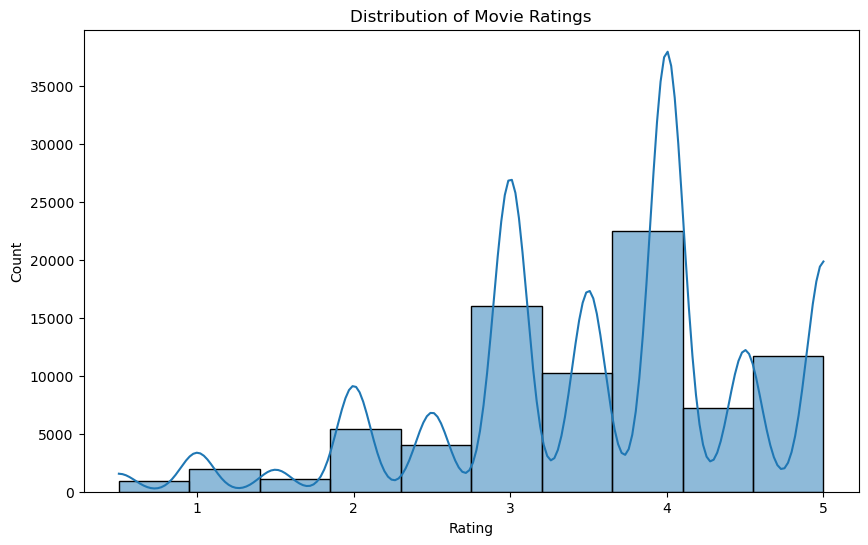

In [7]:
# Visualisera betygsfördelning
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Denna visualisering hjälper oss att förstå hur betygen är fördelade,
# vilket kan ge insikter om användarnas betygsmönster

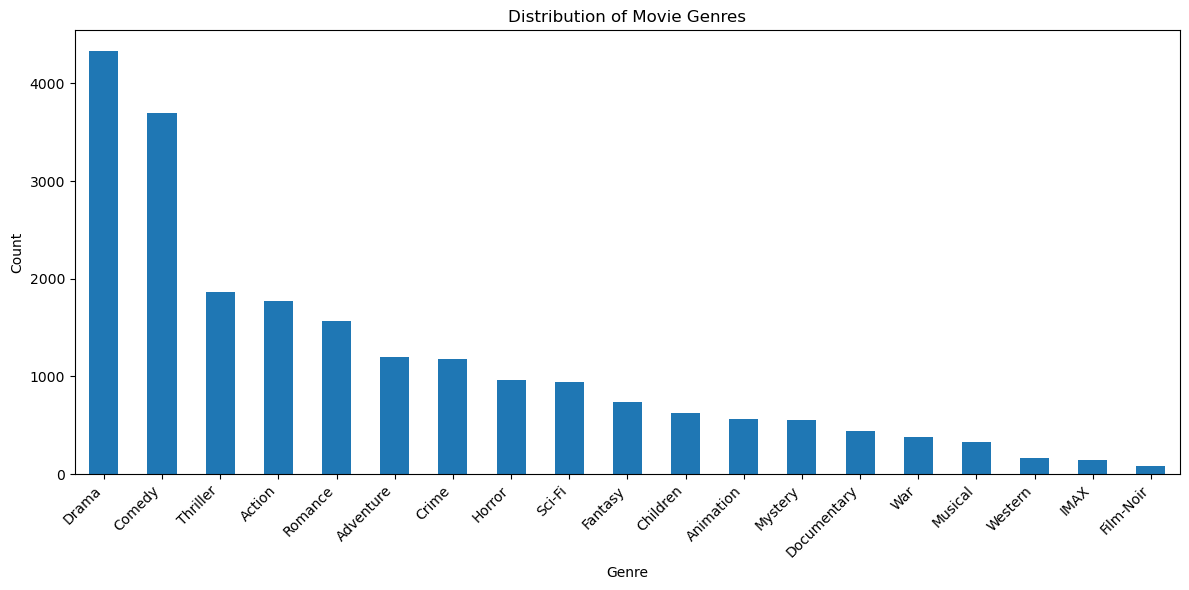

In [8]:
# Analysera genrefördelning
genres = movies['genres'].str.split('|', expand=True).stack()
genre_counts = genres.value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Denna analys visar fördelningen av olika genrer i datasetet,
# vilket kan hjälpa oss att förstå vilka typer av filmer som är mest representerade

In [9]:
# Analysera tidstrender i betyg
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year

yearly_ratings = ratings.groupby('year')['rating'].mean()

plt.figure(figsize=(12, 6))
yearly_ratings.plot()
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

# Denna analys visar hur genomsnittliga betyg har förändrats över tid,
# vilket kan avslöja trender i användarnas betygssättning eller filmkvalitet

ValueError: non convertible value 2000-07-30 18:45:03 with the unit 's', at position 0